In [1]:
%pylab inline
from glob import glob
import h5py
import torch
from torch import Tensor
import torch.nn.functional 
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.transforms import Resize as VisionResize

import sys
sys.path.insert(1, '../models')

from unet import ResnetBlock


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
basePath = '/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps'#'/ocean/projects/phy230064p/shared/superresolution/'
simPath = basePath + '/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy'
dm_map = np.load(simPath)

# density  normalize the data
dm_map = np.log10(dm_map)
dm_map = (dm_map - dm_map.mean()) / dm_map.std()
print ("shape of the data:",dm_map.shape)

dm_map = torch.Tensor(dm_map)
dm_map = dm_map.unsqueeze(1) # (N,H,W) -> (N,C,H,W)
print ("shape of the data:",dm_map.shape)

shape of the data: (405, 256, 256)
shape of the data: torch.Size([405, 1, 256, 256])


In [4]:
class Translate(object):
    """
    Apply translation to the input image
    """
    def __init__(self, ndim):
        self.ndim = ndim
        
    def __call__(self, sample):
        in_img = sample 
        
        shift_dims = tuple(np.arange(self.ndim)-self.ndim)
        shift_pixels = tuple([torch.randint(in_img.shape[d], (1,)).item() for d in shift_dims])

        in_img = torch.roll(in_img, shift_pixels, dims=shift_dims)
        
        return in_img
    

class Flip(object):
    """
    Flip the input images 
    """
    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "flipping is ambiguous for 1D scalars/vectors"

        self.axes = torch.randint(2, (self.ndim,), dtype=torch.bool)
        self.axes = torch.arange(self.ndim)[self.axes]

        in_img = sample

        if in_img.shape[0] == self.ndim:  # flip vector components
            in_img[self.axes] = -in_img[self.axes]

        shifted_axes = (1 + self.axes).tolist()
        in_img = torch.flip(in_img, shifted_axes)

        return in_img
    

class Permutate(object):
    """
    Permutate the input images 
    """
    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "permutation is not necessary for 1D fields"

        self.axes = torch.randperm(self.ndim)
        
        in_img = sample

        if in_img.shape[0] == self.ndim:  # permutate vector components
            in_img = in_img[self.axes]

        shifted_axes = [0] + (1 + self.axes).tolist()
        in_img = in_img.permute(shifted_axes)

        return in_img
    
    

In [5]:
class SupResDataset(Dataset):
    """
    Make the pairs of LR, HR img pairs
    """
    def __init__(self, imgs, lr_size, hr_size, sigma_lr = 0.1, transform=None):
        """
        imgs: original img in shape of (N,C,H,W)
        lr_size: size of low resolution
        hr_size: size of high resolution
        transform: operations of data augmentation, before resizing to HR and LR
        """
        self.imgs = imgs
        self.transform = transform
        self.lr_resize = VisionResize(lr_size, antialias=False)
        self.hr_resize = VisionResize(hr_size, antialias=False)
        self.sigma_lr = sigma_lr
        self.hr_interpolate = lambda x: torch.nn.functional.interpolate(
            x, 
            scale_factor=hr_size / lr_size,
            mode='bilinear', align_corners=False)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        
        if self.transform is not None:
            img = self.transform(img)
        
        LR_img = self.hr_interpolate(self.lr_resize(img)[None]).squeeze(0)
        # add noise
        LR_img = LR_img + torch.randn_like(LR_img) * self.sigma_lr
        HR_img = self.hr_resize(img)
            
        return LR_img, HR_img

In [6]:
ndim = 2
# translation + rotation of the image
train_transforms = transforms.Compose([Translate(ndim),Flip(ndim),Permutate(ndim)]) 

# create the dataset
dataset = SupResDataset(dm_map, lr_size=32, hr_size=128, transform=train_transforms)

# split dataset for training and validation
train_set_size = int(len(dataset) * 0.9)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

# Create train and validation data loaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE)

torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])


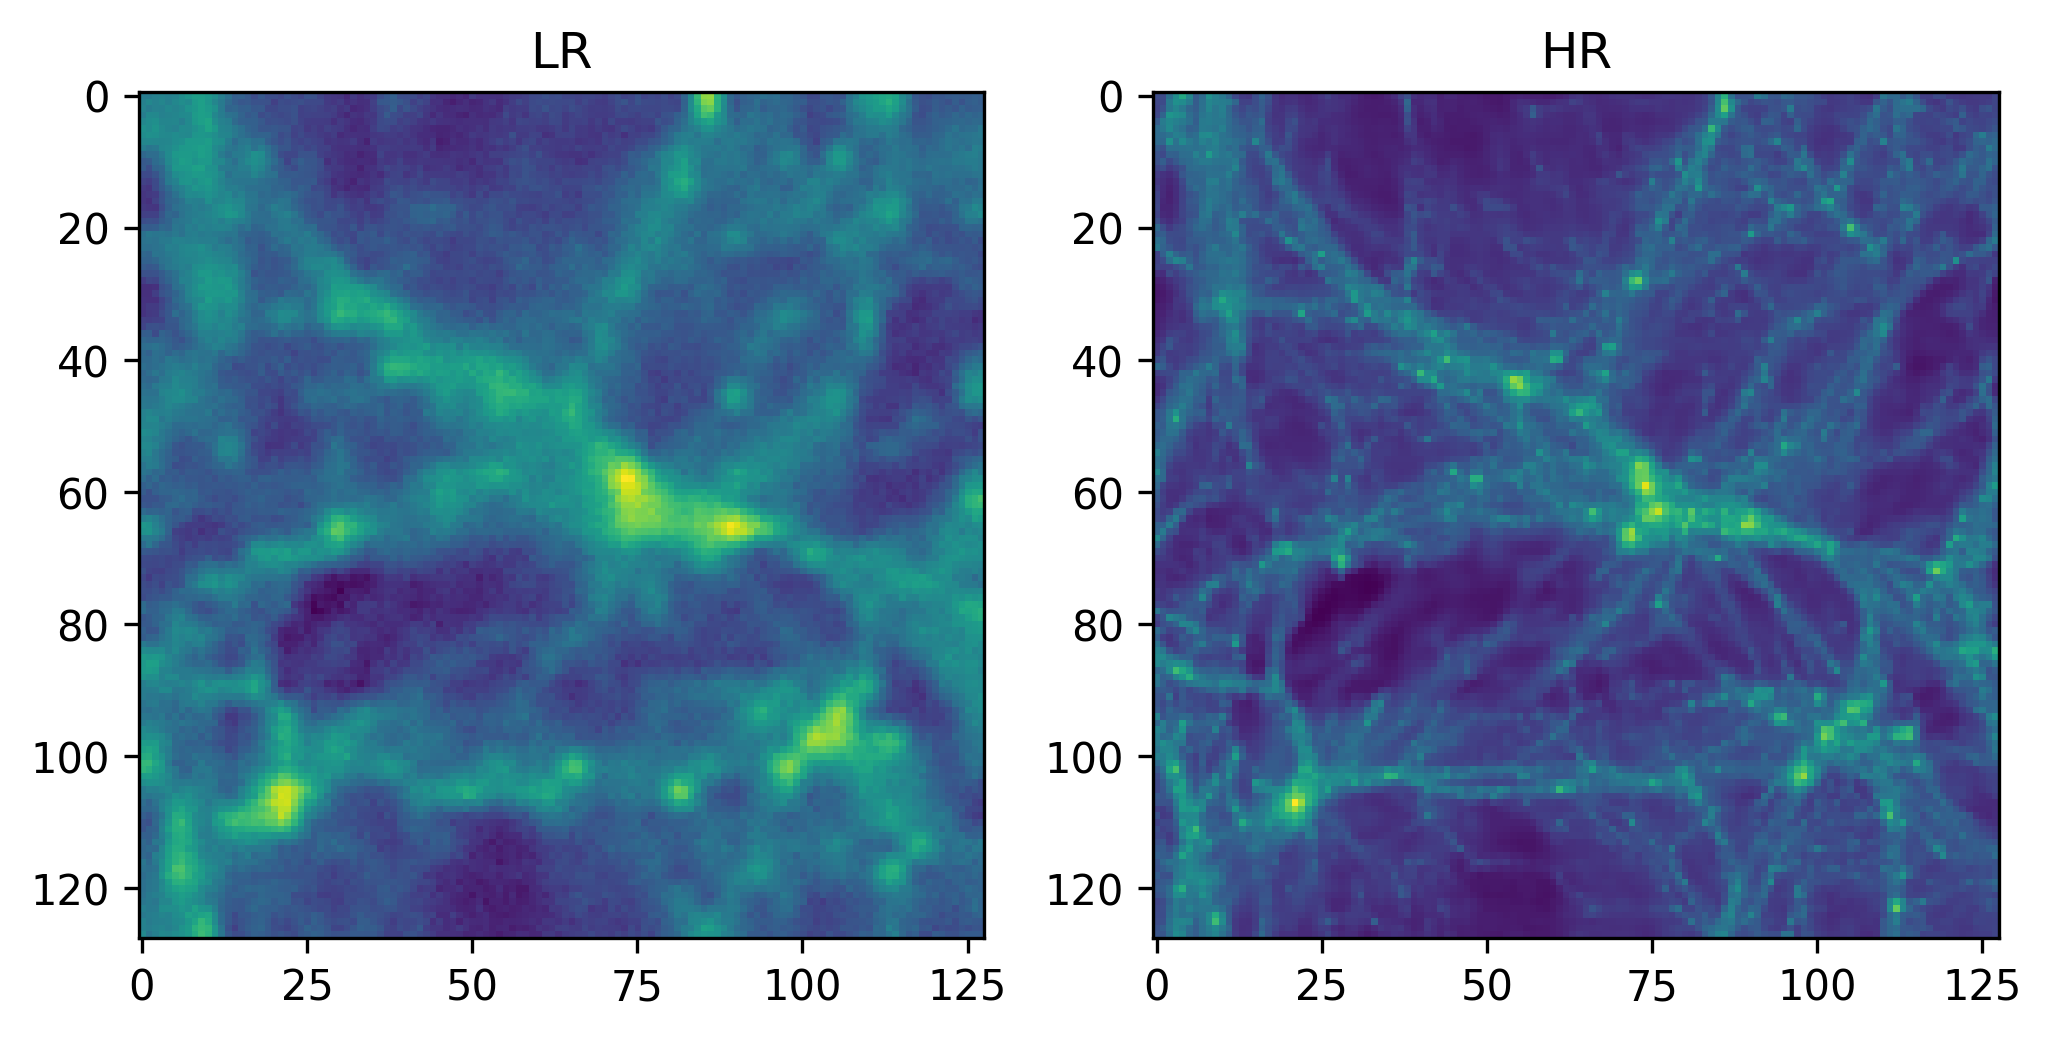

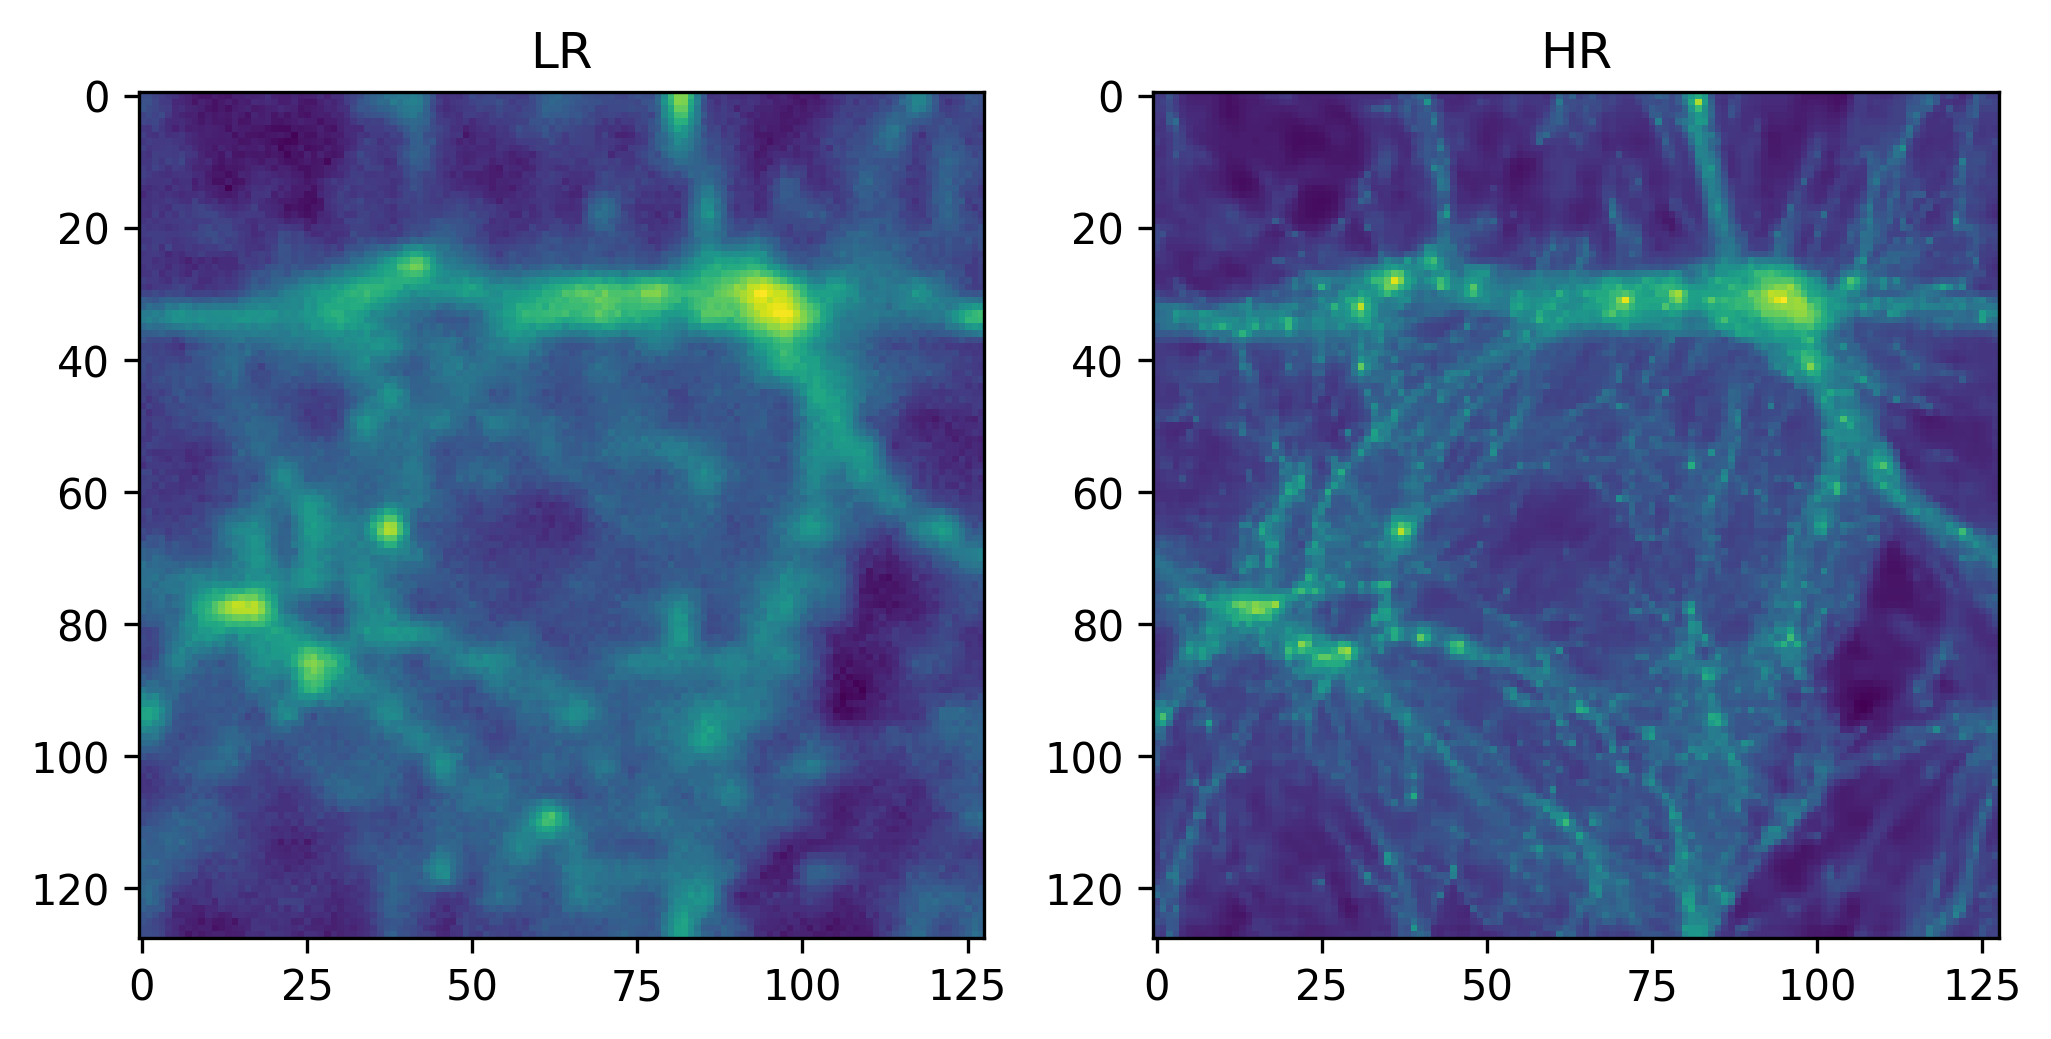

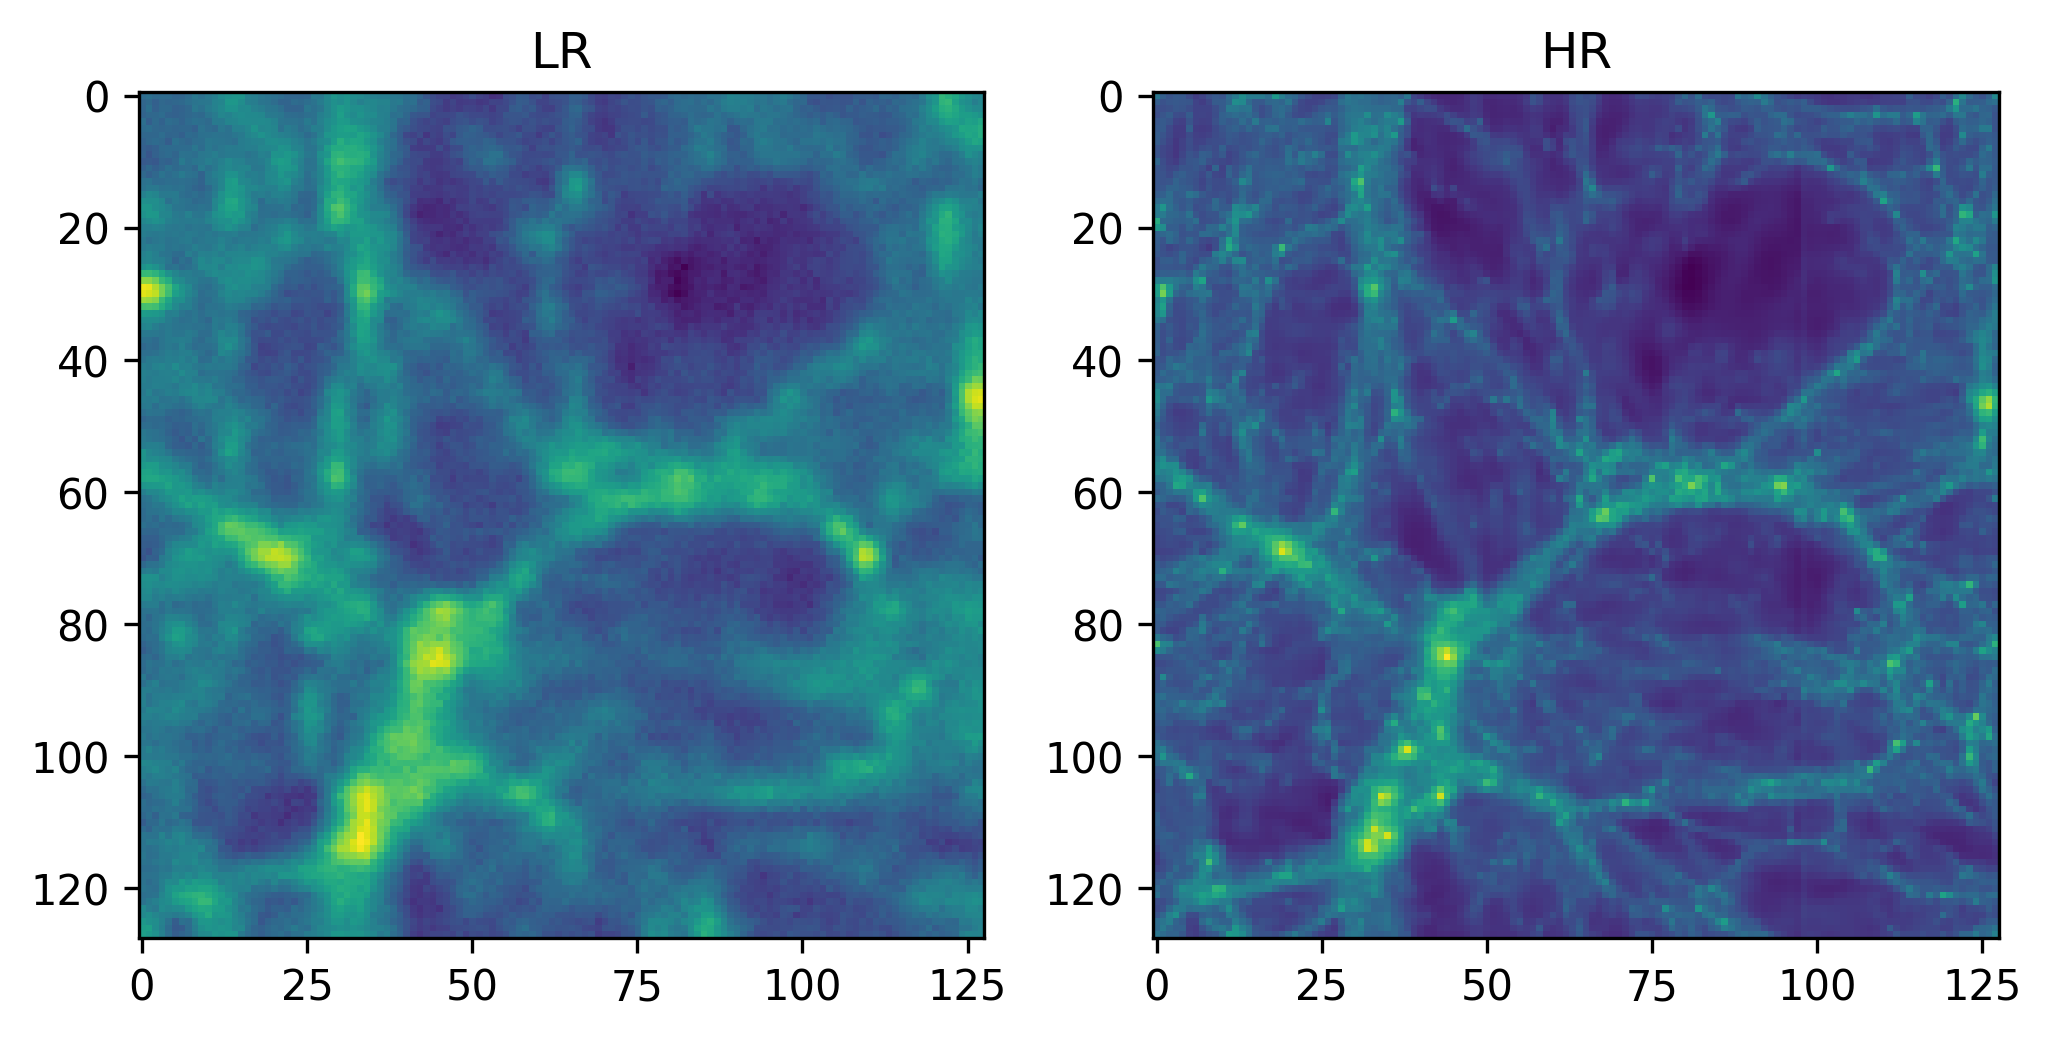

In [7]:
iter_train = iter(train_loader)
for n in range(3):
    lr_img, hr_img = next(iter_train)
    print (lr_img.shape,hr_img.shape)
    fig, ax = plt.subplots(ncols=2,figsize=(8,8))
    ax[0].imshow(lr_img[0].squeeze())
    ax[0].set_title('LR')
    ax[1].imshow(hr_img[0].squeeze())
    ax[1].set_title('HR')

In [8]:
from torchdyn.core import NeuralODE
from lightning import LightningModule, Trainer

class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(t, x)

class FlowMatching(torch.nn.Module):
    def __init__(self, velocity_model):
        super().__init__()
        self.velocity_model = velocity_model
        
    def get_mu_t(self, x0, x1, t):
        return t * x1 + (1 - t) * x0
    
    def get_gamma_t(self,t):
        return torch.sqrt(2*t*(1-t))
    
    def sample_xt(self, x0, x1, t, epsilon):
        t = t.view(t.shape[0], *([1] * (x0.dim() - 1)))
        mu_t = self.get_mu_t(x0, x1, t)
        sigma_t = self.get_gamma_t(t)
        return mu_t #+ sigma_t * epsilon

    def compute_loss(self, x0, x1, t=None,):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        eps = torch.randn_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = x1 - x0
        # should condition on x0 too?
        vt = self.velocity_model(t, xt)
        return torch.mean((vt - ut)**2)
    
    def sample(self, x0, n_sampling_steps=10,):
        node = NeuralODE(
            torch_wrapper(self.velocity_model),
            solver="dopri5",
            sensitivity="adjoint",
        )
        with torch.no_grad():
            traj = node.trajectory(
                x0,
                t_span=torch.linspace(0, 1, n_sampling_steps),
            )
        return traj[-1]

class LightningFlowMatching(LightningModule):
    def __init__(
        self,
        velocity_model,
        learning_rate = 1.e-4,
        n_sampling_steps = 5,
    ):
        super().__init__()

        self.save_hyperparameters('learning_rate', 'n_sampling_steps')
        self.fm = FlowMatching(
            velocity_model = velocity_model,
        )

    def setup(self, stage):
        if stage == 'fit':
            self.fm = self.fm.to(self.device)
            
    def training_step(self, batch, batch_idx):
        low_res, high_res = batch
        loss = self.fm.compute_loss(low_res, high_res)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # we are going to generate some example images while training the model to check that it is generating
        # sensible things
        low_res, high_res = batch
        if batch_idx == 0:
            wandb_logger = self.logger.experiment
            sampled_images = self.fm.sample(low_res, n_sampling_steps=self.hparams.n_sampling_steps)
            fig, ax = plt.subplots(ncols=3,figsize=(10,3))
            labels = ['LR','HR','SR (sample)']
            for i,ds in enumerate([low_res[0], high_res[0], sampled_images[0]]):
                x = ds.squeeze().cpu().numpy()
                x = np.moveaxis(x,0,-1)
                ax[i].imshow(x)
                ax[i].set_title(labels[i],fontsize=15)
            wandb_logger.log({"images": plt})
            plt.close()
        loss = self.fm.compute_loss(low_res, high_res)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self,):
        optimizer = torch.optim.Adam(self.fm.parameters(), lr=self.hparams.learning_rate, betas = (0.9,0.99))
        return optimizer

In [9]:
from torch import nn

def get_timestep_embedding(
    timesteps,
    embedding_dim: int,
    dtype=torch.float32,
    max_timescale=10000,
    min_timescale=1,
):
    # Scale timesteps by a factor of 1000
    timesteps *= 1000
    # Ensure timesteps is a 1-dimensional tensor
    assert timesteps.ndim == 1
    assert embedding_dim % 2 == 0

    num_timescales = embedding_dim // 2
    # Create a tensor of inverse timescales logarithmically spaced
    inv_timescales = torch.logspace(
        -np.log10(min_timescale),
        -np.log10(max_timescale),
        num_timescales,
        device=timesteps.device,
    )
    
    emb = timesteps.to(dtype)[:, None] * inv_timescales[None, :]  # Shape: (T, D/2)
    # Return the concatenation of sine and cosine of the embedding
    return torch.cat([emb.sin(), emb.cos()], dim=1)  # Shape: (T, D)

class UNetVDM(nn.Module):
    def __init__(
        self,
        scale_factor: int = 1,
        embedding_dim: int = 128,
        norm_groups: int = 32,
        dropout_prob: float = 0.1,
        input_channels: int = 1,
        conditioning_channels: int = 1,
        n_blocks: int = 32,
        gamma_min: float = -13.3,
        gamma_max: float = 13.3,
    ):
        super().__init__()
        
        self.scale_factor = scale_factor
        self.embedding_dim = embedding_dim
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        
        resnet_params = dict(
            ch_in=embedding_dim,
            ch_out=embedding_dim,
            condition_dim=4 * embedding_dim,
            dropout_prob=dropout_prob,
            norm_groups=norm_groups,
        )
        
        self.embed_conditioning = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(embedding_dim * 4, embedding_dim * 4),
            nn.SiLU(),
        )
        
        total_input_ch = input_channels + conditioning_channels
        
        self.conv_in = nn.Conv2d(total_input_ch, embedding_dim, 3, padding=1)
        
        # Down path: n_blocks blocks with a resnet block and maybe attention.
        self.down_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks)
        )

        self.mid_resnet_block_1 = ResnetBlock(**resnet_params)
        self.mid_resnet_block_2 = ResnetBlock(**resnet_params)

        # Up path: n_blocks+1 blocks with a resnet block and maybe attention.
        resnet_params["ch_in"] *= 2  # double input channels due to skip connections
        self.up_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks + 1)
        )

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=embedding_dim),
            nn.SiLU(),
            zero_init(nn.Conv2d(embedding_dim, input_channels, 3, padding=1)),
        )

    def forward(
        self,
        g_t,
        z,
        conditioning=None,
    ):
        
        if conditioning is not None:
            if self.scale_factor>1:
                conditioning = torch.nn.functional.interpolate(conditioning, scale_factor=self.scale_factor,
                                             mode='bilinear', align_corners=False)
            z_concat = torch.concat(
                (z, conditioning),
                axis=1,
            )
        else:
            z_concat = z
        
        # Get gamma to shape (B, ).
        g_t = g_t.expand(z_concat.shape[0])  # assume shape () or (1,) or (B,)
        assert g_t.shape == (z_concat.shape[0],)
        # Rescale to [0, 1], but only approximately since gamma0 & gamma1 are not fixed.
        g_t = (g_t - self.gamma_min) / (self.gamma_max - self.gamma_min)
        t_embedding = get_timestep_embedding(g_t, self.embedding_dim)
        # We will condition on time embedding.
        cond = self.embed_conditioning(t_embedding)
        h = self.conv_in(z_concat)  # (B, embedding_dim, H, W)
        hs = []
        for down_block in self.down_blocks:  # n_blocks times
            hs.append(h)
            h = down_block(h, cond)
        hs.append(h)
        h = self.mid_resnet_block_1(h, cond)
        h = self.mid_resnet_block_2(h, cond)
        for up_block in self.up_blocks:  # n_blocks+1 times
            h = torch.cat([h, hs.pop()], dim=1)
            h = up_block(h, cond)
        prediction = self.conv_out(h)
        return prediction + z

In [10]:
@torch.no_grad()
def zero_init(module: torch.nn.Module) -> torch.nn.Module:
    """Sets to zero all the parameters of a module, and returns the module."""
    for p in module.parameters():
        torch.nn.init.zeros_(p.data)
    return module

model = UNetVDM(
    scale_factor = 4, # our SR task upscale the spatial resolution by 4 times
    embedding_dim=48, 
    norm_groups = 8,
    n_blocks = 4,
    input_channels = 1, # For galaxy images with 3 channels (RGB)
    conditioning_channels = 0,
)


In [11]:
flow_matching = LightningFlowMatching(
    velocity_model=model,
)

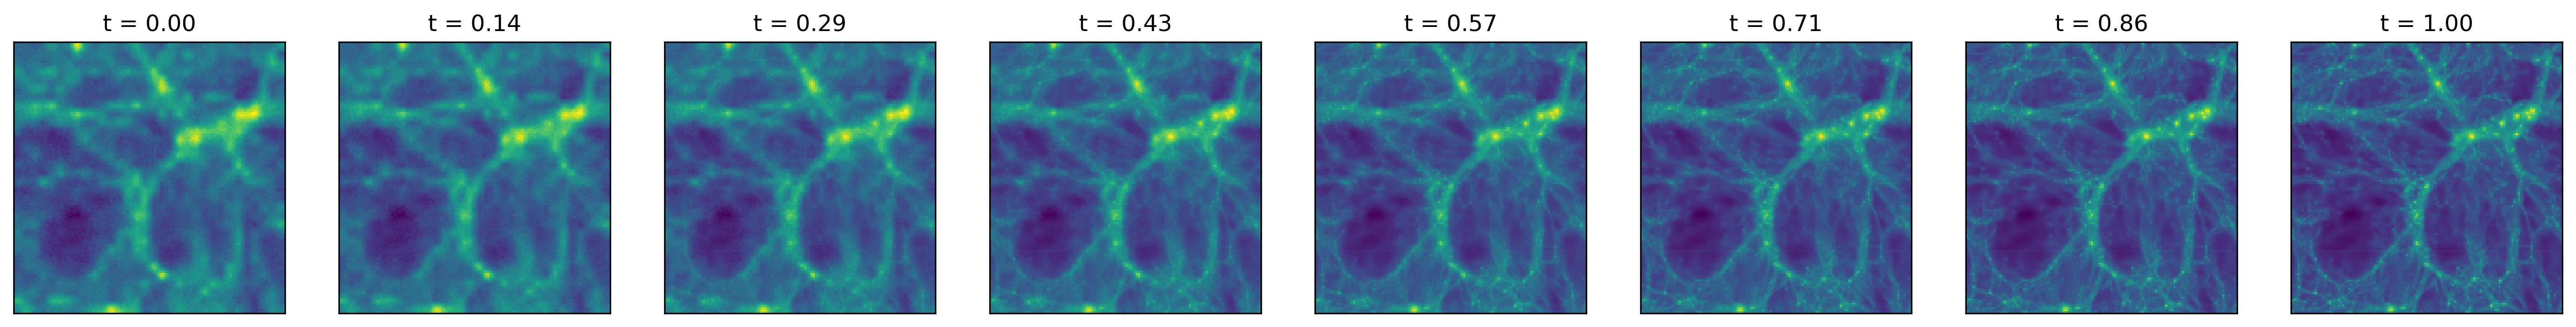

In [12]:
# Adding Noise
times = torch.Tensor(np.linspace(0.,1., 8), )

fig, ax = plt.subplots(ncols=len(times),figsize=(24,4))
for i, time in enumerate(times):
    epsilon = torch.randn_like(lr_img[0])
    noisy_sample = flow_matching.fm.sample_xt(lr_img[0], hr_img[0],torch.Tensor([time]), epsilon)
    x = noisy_sample.squeeze().cpu().numpy()
    x = np.moveaxis(x,0,-1)
    ax[i].imshow(x)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f't = {time:.2f}')
    
# fig.savefig('gal-diffusion.png',dpi=100,bbox_inches='tight')

In [13]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="IAIFI_HACK", log_model="all")

In [14]:
trainer = Trainer(
    max_steps = 100_000, gradient_clip_val=0.5, logger=wandb_logger, log_every_n_steps=10, val_check_interval=60
)
trainer.fit(
    model=flow_matching, 
    train_dataloaders=train_loader, 
    val_dataloaders = val_loader,
)

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/torch/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environm

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | fm   | FlowMatching | 735 K 
--------------------------------------
735 K     Trainable params
0         Non-trainable params
735 K     Total params
2.943     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/torch/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [15]:
lr_img, hr_img = dataset[0]

In [16]:
# convergence with number of steps 

steps = [2,8,32,64,128]
sampled_images = []
for stepping in steps:
    sampled_images.append(flow_matching.fm.sample(lr_img.cuda()[None], n_sampling_steps=stepping))


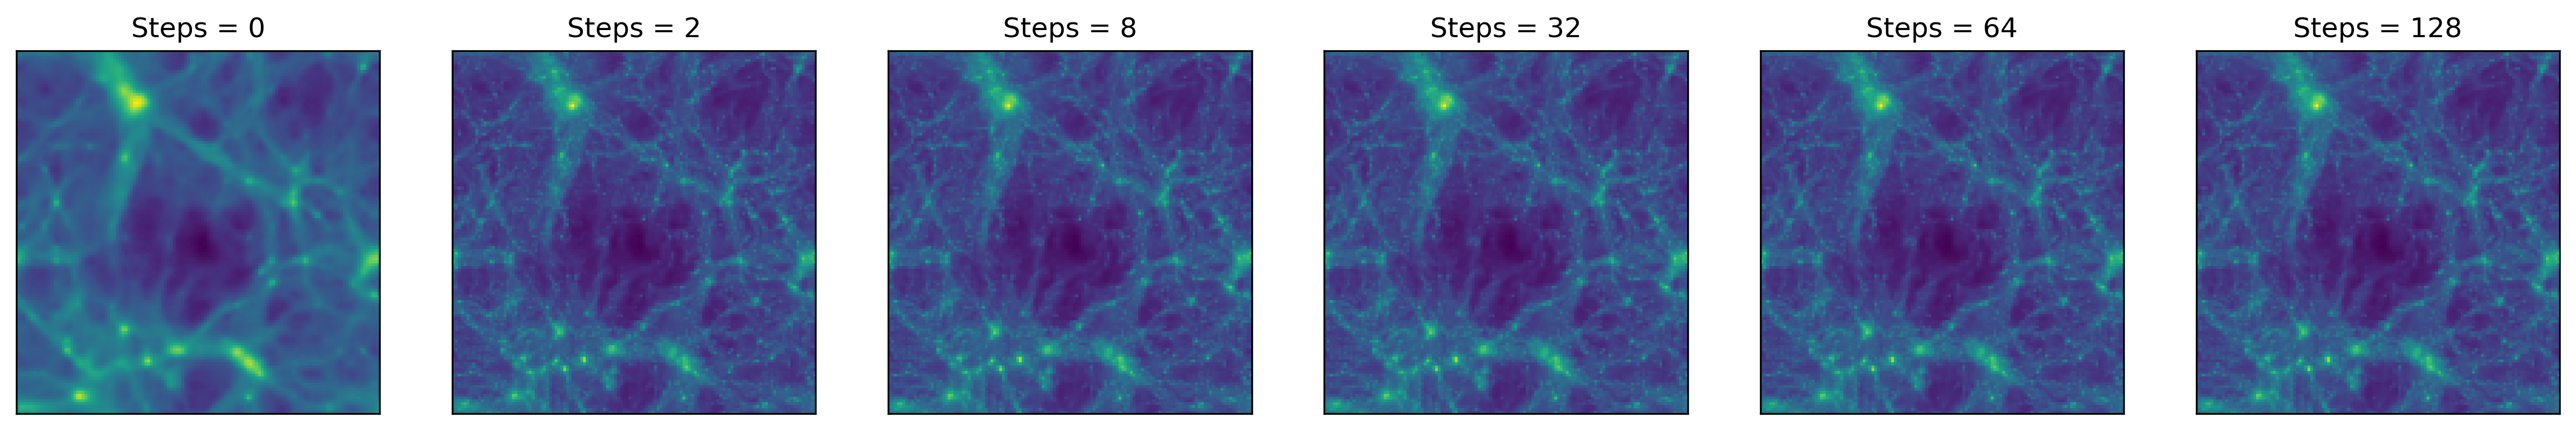

In [17]:
fig, ax = plt.subplots(ncols=6, figsize=(20,6))
one_step_pred = lr_img.cuda() + flow_matching.fm.velocity_model(torch.Tensor([0.]).cuda(), lr_img.cuda()[None])
ax[0].set_title(f'Steps = 0')
ax[0].imshow(one_step_pred[0].detach().cpu().numpy()[0].squeeze())
ax[0].set_xticks([])
ax[0].set_yticks([])
for i, step in enumerate(steps):
    ax[i+1].set_title(f'Steps = {step}')
    ax[i+1].imshow(sampled_images[i].detach().cpu().numpy()[0].squeeze())
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])


In [18]:
test_data = SupResDataset(dm_map, lr_size=32, hr_size=128, transform=None)

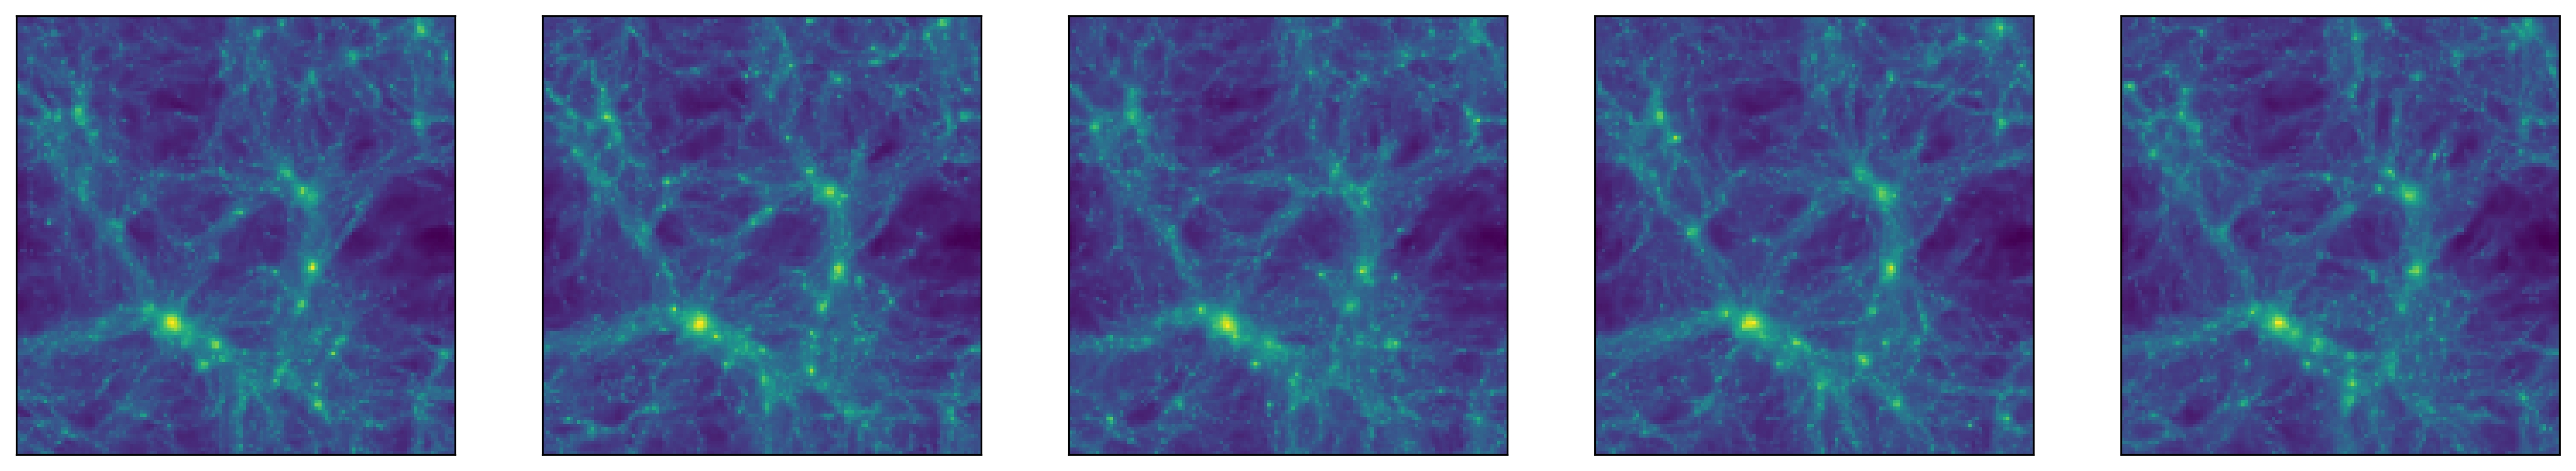

In [19]:
# same LR, different noise samples
fig, ax = plt.subplots(ncols=5, figsize=(20,6))
for i in range(5):
    lr_img, hr_img = test_data[0]
    sampled_hr = flow_matching.fm.sample(lr_img.cuda()[None], n_sampling_steps=5)
    ax[i].imshow(sampled_hr.detach().cpu().squeeze())
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    